In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

In [2]:

data = pd.read_csv('Filtered-Data.csv')
correlation_threshold = 0.8


In [3]:

X = data.drop(['Class'], axis=1)
y = data['Class']


In [4]:
# Compute pairwise correlations
correlation_matrix = X.corr()

In [5]:

correlated_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_pairs.add((colname, correlation_matrix.index[j]))

In [6]:

for pair in correlated_pairs:
    feature_to_drop = pair[1]
    if feature_to_drop in X.columns:
        X = X.drop(feature_to_drop, axis=1)

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
class_weights = {0: 2, 1: 2, 2: 1}

In [9]:
len(X_train.columns)

2028

In [10]:

rf_model = RandomForestClassifier(
    class_weight=class_weights,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)


In [11]:

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 2, 1: 2, 2: 1}, max_depth=20,
                       random_state=42)

In [12]:

feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [13]:
zero_importance_features = feature_importance_df[feature_importance_df['Importance'] == 0]['Feature'].tolist()

# Drop zero-importance features from the dataset
X_train = X_train.drop(zero_importance_features, axis=1)
X_test = X_test.drop(zero_importance_features, axis=1)

In [14]:
len(zero_importance_features)

1145

In [15]:
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.89333333 0.89333333 0.89932886 0.89932886 0.89261745]
Mean Accuracy: 0.8955883668903803


In [16]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 2, 1: 2, 2: 1}, max_depth=20,
                       random_state=42)

In [17]:
len(X_test.columns)

883

In [18]:

y_pred_adjusted = rf_model.predict(X_test)

In [19]:

print(classification_report(y_test, y_pred_adjusted, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        14
           1       1.00      0.00      0.00         5
           2       0.87      1.00      0.93       131

    accuracy                           0.87       150
   macro avg       0.96      0.33      0.31       150
weighted avg       0.89      0.87      0.81       150



In [20]:

y_prob = rf_model.predict_proba(X_test)
auc_roc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f'AUC-ROC: {auc_roc}')


AUC-ROC: 0.492095688138793


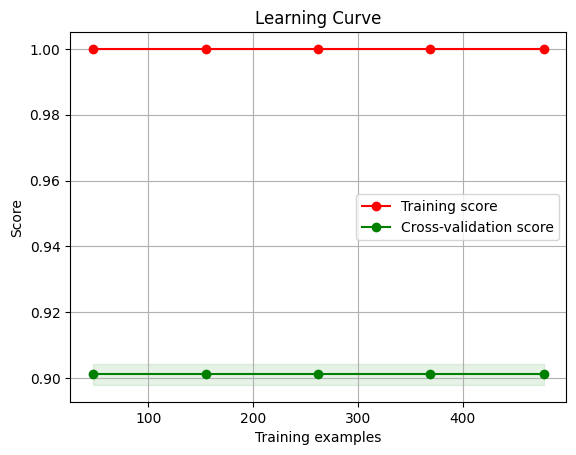

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(rf_model, "Learning Curve", X_train, y_train, cv=5, n_jobs=-1)
plt.show()
